# Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from IPython.display import Image,display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import datetime
import json
import warnings 

warnings.filterwarnings('ignore')

# Data Preperation

In [2]:
df = pd.read_csv("../data/USD-EUR-GBP to EGP Time series Data clean.csv",index_col='Date')
df.index = pd.to_datetime(df.index)
df[["USD","EUR","GBP"]] =  df[["USD","EUR","GBP"]].apply(pd.to_numeric)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6241 entries, 2003-12-01 23:58:00 to 2023-03-31 23:58:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   USD     6241 non-null   float64
 1   EUR     6241 non-null   float64
 2   GBP     6241 non-null   float64
dtypes: float64(3)
memory usage: 195.0 KB


In [4]:
df.describe()

,USD,EUR,GBP
count,6241.000000,6241.000000,6241.000000
mean,10.600241,12.577217,15.092249
std,5.825124,6.009337,6.371359
min,5.193900,6.462902,7.535949
25%,5.793900,7.792321,10.252250
50%,7.128000,8.980627,11.417500
75%,15.974230,18.659000,21.378700
max,30.950200,33.690000,38.272130


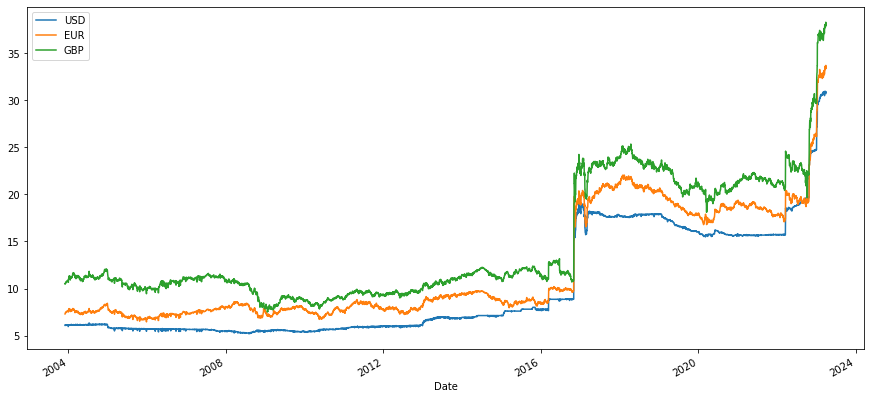

In [5]:
df[["USD","EUR","GBP"]].plot(figsize = (15,7));

#### only take data from dates after 2016 and before 2018, as it is more representing of current data.

In [6]:
df_train = df.loc[datetime.date(year=2016,month=1,day=1):datetime.date(year=2020,month=1,day=1)]

df_test = df.loc[:]


#### scale each column with Min - Max scaling

In [7]:
scaler = MinMaxScaler(feature_range = (0,1))

In [8]:
df_train_s = pd.DataFrame()
df_train_s[['USDs','EURs','GBPs']] = scaler.fit_transform(df_train)


df_test_s = pd.DataFrame()
df_test_s [['USDs','EURs','GBPs']] = scaler.fit_transform(df_test)


In [9]:
df_train.describe()

,USD,EUR,GBP
count,1460.000000,1460.000000,1460.000000
mean,15.598962,17.747050,20.394722
std,3.672944,4.361177,4.595024
min,7.645900,8.330132,10.689083
25%,16.098890,17.811000,20.114750
50%,17.605000,19.599335,22.712550
75%,17.860000,20.720705,23.352007
max,19.603000,22.046214,25.340547


In [10]:
df_test.describe()

,USD,EUR,GBP
count,6241.000000,6241.000000,6241.000000
mean,10.600241,12.577217,15.092249
std,5.825124,6.009337,6.371359
min,5.193900,6.462902,7.535949
25%,5.793900,7.792321,10.252250
50%,7.128000,8.980627,11.417500
75%,15.974230,18.659000,21.378700
max,30.950200,33.690000,38.272130


#### split into features and labels

In [11]:
x_train = df_train_s.to_numpy()
y_train = df_train_s.iloc[:,0].to_numpy()

x_test = df_test_s.to_numpy()
y_test = df_test_s.iloc[:,0].to_numpy()

#### ( 2016 - 2020 ) training data

In [12]:
x_train.shape

(1460, 3)

In [13]:
y_train.shape

(1460,)

#### testing data ~ ( 2003 -  2023)

In [14]:
x_test.shape

(6241, 3)

In [15]:
y_test.shape

(6241,)

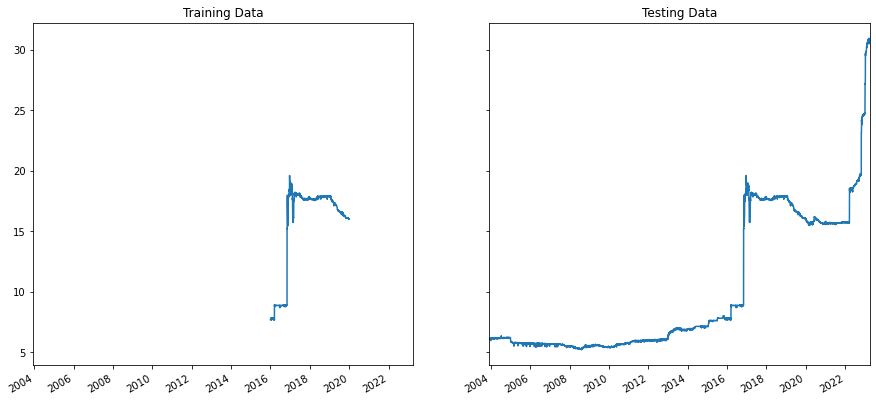

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey = True,figsize = (15,7))


ax1.plot(df_train.index.to_pydatetime() ,df_train[["USD"]]);

ax2.plot(df_test.index.to_pydatetime() ,df_test[["USD"]]);

fig.autofmt_xdate()

ax1.set_xlim([df.index.min(), df.index.max()]);
ax2.set_xlim([df.index.min(), df.index.max()]);
ax1.set_title("Training Data");
ax2.set_title("Testing Data");

# 3.0 Modeling

#### Create generator for testing and tranning

In [17]:
days_found = 9
days_to_find =1
days = days_to_find + days_found
train_generator = TimeseriesGenerator(
    x_train,
    y_train,
    length = days,
    sampling_rate= 1,
    batch_size = 10
)
test_generator = TimeseriesGenerator(
    x_test,
    y_test,
    length = days,
    sampling_rate= 1,
    batch_size = 10
)

#### Model 

In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128 , input_shape = (days,3),return_sequences =True))
model.add(tf.keras.layers.LSTM(64 , return_sequences = False))
model.add(tf.keras.layers.Dense(16,activation='LeakyReLU'))
model.add(tf.keras.layers.Dense(1,activation='linear'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           67584     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 118,049
Trainable params: 118,049
Non-trainable params: 0
_________________________________________________________________


#### Use MAE as loss function
and moniter RMSE, MSE

In [20]:
model.compile(
            loss = tf.losses.MeanAbsoluteError(),
            optimizer = tf.optimizers.Adagrad(),
            metrics = [
                        tf.keras.metrics.RootMeanSquaredError(),
                        tf.keras.metrics.MeanAbsoluteError(),
                        tf.keras.metrics.MeanSquaredError()
                      ]
             ) 

In [21]:
history = model.fit_generator(train_generator, epochs = 250, validation_data = test_generator,shuffle = False)           

Epoch 1/250
145/145 [==============================] - 6s 25ms/step - loss: 0.3193 - root_mean_squared_error: 0.4079 - mean_absolute_error: 0.3193 - mean_squared_error: 0.1664 - val_loss: 0.2100 - val_root_mean_squared_error: 0.2248 - val_mean_absolute_error: 0.2100 - val_mean_squared_error: 0.0505
Epoch 2/250
145/145 [==============================] - 3s 19ms/step - loss: 0.0663 - root_mean_squared_error: 0.1135 - mean_absolute_error: 0.0663 - mean_squared_error: 0.0129 - val_loss: 0.1902 - val_root_mean_squared_error: 0.2026 - val_mean_absolute_error: 0.1902 - val_mean_squared_error: 0.0411
Epoch 3/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0600 - root_mean_squared_error: 0.1031 - mean_absolute_error: 0.0600 - mean_squared_error: 0.0106 - val_loss: 0.1721 - val_root_mean_squared_error: 0.1833 - val_mean_absolute_error: 0.1721 - val_mean_squared_error: 0.0336
Epoch 4/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0557 - root_mean_squar

145/145 [==============================] - 3s 20ms/step - loss: 0.0185 - root_mean_squared_error: 0.0441 - mean_absolute_error: 0.0185 - mean_squared_error: 0.0019 - val_loss: 0.0264 - val_root_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.0264 - val_mean_squared_error: 9.9435e-04
Epoch 29/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0185 - root_mean_squared_error: 0.0441 - mean_absolute_error: 0.0185 - mean_squared_error: 0.0019 - val_loss: 0.0263 - val_root_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.0263 - val_mean_squared_error: 9.8876e-04
Epoch 30/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0185 - root_mean_squared_error: 0.0441 - mean_absolute_error: 0.0185 - mean_squared_error: 0.0019 - val_loss: 0.0262 - val_root_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.0262 - val_mean_squared_error: 9.8190e-04
Epoch 31/250
145/145 [==============================] - 3s 19ms/step - loss: 0.0185 - root_mean_sq

Epoch 55/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0182 - root_mean_squared_error: 0.0436 - mean_absolute_error: 0.0182 - mean_squared_error: 0.0019 - val_loss: 0.0238 - val_root_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 8.4538e-04
Epoch 56/250
145/145 [==============================] - 3s 19ms/step - loss: 0.0183 - root_mean_squared_error: 0.0436 - mean_absolute_error: 0.0183 - mean_squared_error: 0.0019 - val_loss: 0.0238 - val_root_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 8.4595e-04
Epoch 57/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0182 - root_mean_squared_error: 0.0436 - mean_absolute_error: 0.0182 - mean_squared_error: 0.0019 - val_loss: 0.0237 - val_root_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.0237 - val_mean_squared_error: 8.4084e-04
Epoch 58/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0182 -

Epoch 82/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0174 - root_mean_squared_error: 0.0430 - mean_absolute_error: 0.0174 - mean_squared_error: 0.0018 - val_loss: 0.0211 - val_root_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.0211 - val_mean_squared_error: 7.0710e-04
Epoch 83/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0174 - root_mean_squared_error: 0.0430 - mean_absolute_error: 0.0174 - mean_squared_error: 0.0018 - val_loss: 0.0211 - val_root_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.0211 - val_mean_squared_error: 7.0403e-04
Epoch 84/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0173 - root_mean_squared_error: 0.0429 - mean_absolute_error: 0.0173 - mean_squared_error: 0.0018 - val_loss: 0.0209 - val_root_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.0209 - val_mean_squared_error: 6.9760e-04
Epoch 85/250
145/145 [==============================] - 3s 19ms/step - loss: 0.0173 -

Epoch 109/250
145/145 [==============================] - 3s 22ms/step - loss: 0.0162 - root_mean_squared_error: 0.0422 - mean_absolute_error: 0.0162 - mean_squared_error: 0.0018 - val_loss: 0.0183 - val_root_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.0183 - val_mean_squared_error: 5.7760e-04
Epoch 110/250
145/145 [==============================] - 3s 21ms/step - loss: 0.0161 - root_mean_squared_error: 0.0422 - mean_absolute_error: 0.0161 - mean_squared_error: 0.0018 - val_loss: 0.0181 - val_root_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.0181 - val_mean_squared_error: 5.7064e-04
Epoch 111/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0162 - root_mean_squared_error: 0.0422 - mean_absolute_error: 0.0162 - mean_squared_error: 0.0018 - val_loss: 0.0181 - val_root_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.0181 - val_mean_squared_error: 5.6897e-04
Epoch 112/250
145/145 [==============================] - 3s 21ms/step - loss: 0.01

Epoch 136/250
145/145 [==============================] - 3s 22ms/step - loss: 0.0151 - root_mean_squared_error: 0.0416 - mean_absolute_error: 0.0151 - mean_squared_error: 0.0017 - val_loss: 0.0155 - val_root_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.0155 - val_mean_squared_error: 4.6353e-04
Epoch 137/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0150 - root_mean_squared_error: 0.0416 - mean_absolute_error: 0.0150 - mean_squared_error: 0.0017 - val_loss: 0.0153 - val_root_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.0153 - val_mean_squared_error: 4.5680e-04
Epoch 138/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0149 - root_mean_squared_error: 0.0416 - mean_absolute_error: 0.0149 - mean_squared_error: 0.0017 - val_loss: 0.0152 - val_root_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.0152 - val_mean_squared_error: 4.5347e-04
Epoch 139/250
145/145 [==============================] - 3s 20ms/step - loss: 0.01

Epoch 163/250
145/145 [==============================] - 3s 22ms/step - loss: 0.0139 - root_mean_squared_error: 0.0409 - mean_absolute_error: 0.0139 - mean_squared_error: 0.0017 - val_loss: 0.0131 - val_root_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.0131 - val_mean_squared_error: 3.7849e-04
Epoch 164/250
145/145 [==============================] - 3s 21ms/step - loss: 0.0138 - root_mean_squared_error: 0.0409 - mean_absolute_error: 0.0138 - mean_squared_error: 0.0017 - val_loss: 0.0131 - val_root_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.0131 - val_mean_squared_error: 3.7592e-04
Epoch 165/250
145/145 [==============================] - 3s 21ms/step - loss: 0.0138 - root_mean_squared_error: 0.0408 - mean_absolute_error: 0.0138 - mean_squared_error: 0.0017 - val_loss: 0.0130 - val_root_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.0130 - val_mean_squared_error: 3.7352e-04
Epoch 166/250
145/145 [==============================] - 3s 23ms/step - loss: 0.01

Epoch 190/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0127 - root_mean_squared_error: 0.0403 - mean_absolute_error: 0.0127 - mean_squared_error: 0.0016 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0111 - val_mean_squared_error: 3.1377e-04
Epoch 191/250
145/145 [==============================] - 3s 23ms/step - loss: 0.0127 - root_mean_squared_error: 0.0403 - mean_absolute_error: 0.0127 - mean_squared_error: 0.0016 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0111 - val_mean_squared_error: 3.1255e-04
Epoch 192/250
145/145 [==============================] - 3s 23ms/step - loss: 0.0127 - root_mean_squared_error: 0.0402 - mean_absolute_error: 0.0127 - mean_squared_error: 0.0016 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0111 - val_mean_squared_error: 3.1122e-04
Epoch 193/250
145/145 [==============================] - 3s 23ms/step - loss: 0.01

Epoch 217/250
145/145 [==============================] - 3s 20ms/step - loss: 0.0118 - root_mean_squared_error: 0.0397 - mean_absolute_error: 0.0118 - mean_squared_error: 0.0016 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0096 - val_mean_squared_error: 2.6714e-04
Epoch 218/250
145/145 [==============================] - 3s 21ms/step - loss: 0.0118 - root_mean_squared_error: 0.0397 - mean_absolute_error: 0.0118 - mean_squared_error: 0.0016 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0095 - val_mean_squared_error: 2.6468e-04
Epoch 219/250
145/145 [==============================] - 3s 22ms/step - loss: 0.0118 - root_mean_squared_error: 0.0397 - mean_absolute_error: 0.0118 - mean_squared_error: 0.0016 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0095 - val_mean_squared_error: 2.6296e-04
Epoch 220/250
145/145 [==============================] - 3s 20ms/step - loss: 0.01

Epoch 244/250
145/145 [==============================] - 3s 21ms/step - loss: 0.0111 - root_mean_squared_error: 0.0392 - mean_absolute_error: 0.0111 - mean_squared_error: 0.0015 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 2.3200e-04
Epoch 245/250
145/145 [==============================] - 3s 22ms/step - loss: 0.0110 - root_mean_squared_error: 0.0392 - mean_absolute_error: 0.0110 - mean_squared_error: 0.0015 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 2.3158e-04
Epoch 246/250
145/145 [==============================] - 3s 22ms/step - loss: 0.0110 - root_mean_squared_error: 0.0392 - mean_absolute_error: 0.0110 - mean_squared_error: 0.0015 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0084 - val_mean_squared_error: 2.3087e-04
Epoch 247/250
145/145 [==============================] - 3s 21ms/step - loss: 0.01

# Evaluate

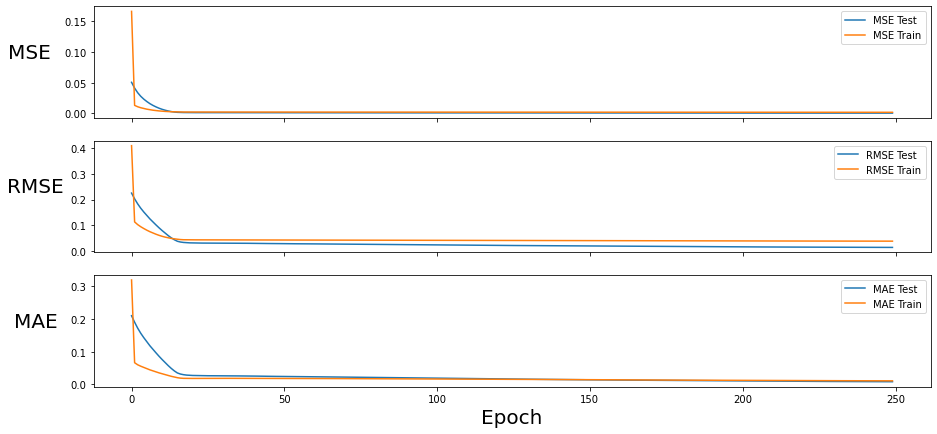

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex = True,figsize = (15,7))

ax1.plot(history.history["val_mean_squared_error"]);
ax1.plot(history.history["mean_squared_error"]);

ax2.plot(history.history["val_root_mean_squared_error"]);
ax2.plot(history.history["root_mean_squared_error"]);


ax3.plot(history.history["val_mean_absolute_error"]);
ax3.plot(history.history["mean_absolute_error"]);

ax1.set_ylabel('MSE',Rotation =0, fontsize=20,labelpad=35)
ax2.set_ylabel('RMSE',Rotation =0, fontsize=20,labelpad=35)
ax3.set_ylabel('MAE',Rotation =0, fontsize=20,labelpad=35)

ax3.set_xlabel('Epoch', fontsize=20)

ax1.legend(['MSE Test','MSE Train'],loc='upper right')
ax2.legend(['RMSE Test','RMSE Train'],loc='upper right')
ax3.legend(['MAE Test','MAE Train'],loc='upper right')

plt.show()


In [23]:
for i in model.metrics_names:
    print(i,round(history.history[i][-1],5),"Train")
    print("val_"+i,round(history.history["val_"+i][-1],5),"Test\n")

loss 0.01093 Train
val_loss 0.00825 Test

root_mean_squared_error 0.03916 Train
val_root_mean_squared_error 0.01504 Test

mean_absolute_error 0.01093 Train
val_mean_absolute_error 0.00825 Test

mean_squared_error 0.00153 Train
val_mean_squared_error 0.00023 Test



#### reverse the normilization
#### add the predicted values to the original values
and plot both

Make predictions from the testing generator and concatinate it to the original values

In [24]:
predictions = model.predict_generator(test_generator)
predictions.shape[0]

6231

In [25]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][days:])] , axis = 1)

In [26]:
df_pred

,0,0,1
0,0.031635,0.038303,0.101221
1,0.031769,0.040581,0.105262
2,0.032058,0.041403,0.106335
3,0.032224,0.040671,0.105969
4,0.032319,0.040780,0.105969
...,...,...,...
6226,0.943696,0.989128,0.991019
6227,0.944988,0.992691,0.994495
6228,0.946323,0.989349,0.988693
6229,0.946675,1.000000,1.000000


reverse the normilization

In [27]:
rev_trans = scaler.inverse_transform(df_pred)

In [28]:
df_end = df[predictions.shape[0]*-1:]
df_end

,USD,EUR,GBP
Date,,,
2003-12-15 23:58:00,6.09730,7.505776,10.647105
2003-12-16 23:58:00,6.14170,7.567803,10.771313
2003-12-17 23:58:00,6.12210,7.590180,10.804282
2003-12-18 23:58:00,6.09570,7.570250,10.793046
2003-12-19 23:58:00,6.11780,7.573225,10.793023
...,...,...,...
2023-03-27 23:58:00,30.89910,33.394000,37.996090
2023-03-28 23:58:00,30.90850,33.491000,38.102930
2023-03-29 23:58:00,30.80190,33.400000,37.924590


In [29]:
df_end["USD-predict"] = rev_trans[:,0]

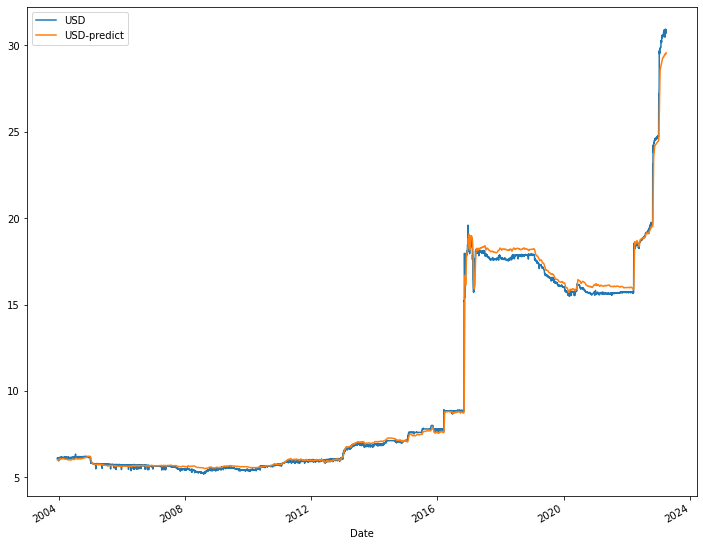

In [30]:
df_end[["USD","USD-predict"]].plot(figsize = (12,10));

# Use the presaved model
- trained on 250 epochs
- as MAE as loss function

In [31]:
model.save("modelG")

INFO:tensorflow:Assets written to: modelG\assets


INFO:tensorflow:Assets written to: modelG\assets


In [32]:
model = keras.models.load_model('modelG')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           67584     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 118,049
Trainable params: 118,049
Non-trainable params: 0
_________________________________________________________________
